In [1101]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:83%; align: left; }</style>"))
display(HTML("<style>#toc-wrapper{ position: relative; width: 20%; top: 130px; left: 0px; }</style>"))

## 데이터 설명

train.csv - 훈련 데이터로 사용되는 승객의 약 2/3(~8700)에 대한 개인 기록입니다.

- PassengerId - 각 승객의 고유 ID입니다. 각 ID는 gggg_pp 형식을 취합니다. 여기서 gggg는 승객이 함께 여행하는 그룹을 나타내고 pp는 그룹 내 번호입니다. 그룹에 속한 사람들은 가족 구성원인 경우가 많지만 항상 그런 것은 아닙니다.
- HomePlanet - 승객이 출발한 행성, 일반적으로 영주권이 있는 행성입니다.
- CryoSleep - 승객이 항해 기간 동안 애니메이션을 정지하도록 선택했는지 여부를 나타냅니다. 냉동 수면 중인 승객은 객실에 갇혀 있습니다.
- Cabin - 승객이 머무르는 객실 번호입니다. Deck/num/side 형식을 취합니다. 여기서 side는 P(Port) 또는 S(Starboard)일 수 있습니다.
- Destination - 승객이 내릴 행성입니다.
- Age - 승객의 나이입니다.
- VIP - 승객이 항해 중 특별 VIP 서비스 비용을 지불했는지 여부.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - 우주선 타이타닉의 다양한 고급 편의시설 각각에 대해 승객이 청구한 금액입니다.
- Name - 승객의 이름과 성입니다.
- Transported - 승객이 다른 차원으로 운송되었는지 여부입니다. 이것이 예측하려는 열인 목표입니다.

test.csv - 나머지 승객의 1/3(~4300명)에 대한 개인 기록이며, 테스트 데이터로 사용됩니다. 귀하의 임무는 이 세트에 있는 승객의 Transported 값을 예측하는 것입니다.

Sample_submission.csv - 올바른 형식의 제출 파일입니다.
- PassengerId - 테스트 세트에 있는 각 승객의 ID입니다.
- Transported - 목표. 각 승객에 대해 True 또는 False를 예측합니다.

## 데이터 로드

In [1102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [1103]:
# 미션 수행을 위해 데이터셋을 로드합니다.
train_df = pd.read_csv('data/spaceship-titanic/train.csv')
test_df = pd.read_csv('data/spaceship-titanic/test.csv')

train_df.shape

(8693, 14)

In [1104]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [1105]:
train_df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [1106]:
# Name의 Null 값 Unknown으로 대체
train_df["Name"] = train_df["Name"].fillna("Unknown")

In [1107]:
# VIP의 Null 값 0으로 대체
train_df["VIP"] = train_df["VIP"].fillna(0)

In [1108]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8693 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8693 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


## 데이터 전처리

### 데이터 분리

In [1109]:
# PaasengerId에서 _ 앞부분은 그룹을 의미 (가족일 수도 있고 아닐 수도)
train_df["Group"] = train_df["PassengerId"].apply(lambda x: x.split("_")[0]).astype(int)
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4


In [1110]:
train_df[["Deck", "Num", "Side"]] = train_df["Cabin"].str.split("/", expand=True)
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Deck,Num,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4,F,1,S


### 범주로 나누기

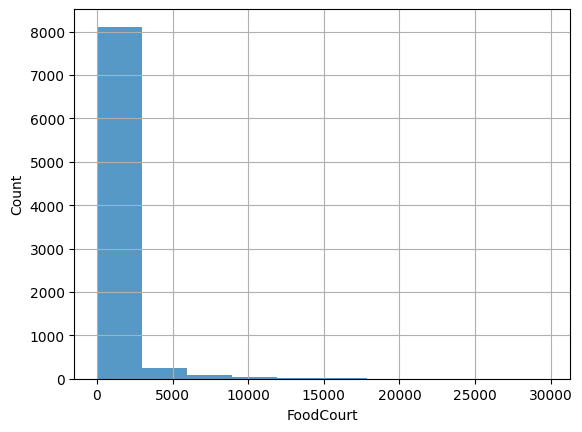

In [1111]:
sns.histplot(data=train_df, x='FoodCourt', bins=10, linewidth=0).grid(True)

In [1112]:
train_df["RoomService_pay"] = train_df["RoomService"] > 0
train_df["FoodCourt_pay"] = train_df["FoodCourt"] > 0
train_df["ShoppingMall_pay"] = train_df["ShoppingMall"] > 0
train_df["Spa_pay"] = train_df["Spa"] > 0
train_df["VRDeck_pay"] = train_df["VRDeck"] > 0

In [1113]:
train_df.nunique()

PassengerId         8693
HomePlanet             3
CryoSleep              2
Cabin               6560
Destination            3
Age                   80
VIP                    2
RoomService         1273
FoodCourt           1507
ShoppingMall        1115
Spa                 1327
VRDeck              1306
Name                8474
Transported            2
Group               6217
Deck                   8
Num                 1817
Side                   2
RoomService_pay        2
FoodCourt_pay          2
ShoppingMall_pay       2
Spa_pay                2
VRDeck_pay             2
dtype: int64

### 결측치

In [1114]:
# 분류하기 쉽도록 이름 대신 num 부여
train_df["HomePlanet_num"] = train_df["HomePlanet"].replace({"Europa":1, "Earth":2,"Mars":3})

In [1115]:
# null 값은 0으로 채움
missing_or_infinite = train_df["HomePlanet_num"].isnull() | ~np.isfinite(train_df["HomePlanet_num"])
train_df["HomePlanet_num"].fillna(value=0, inplace=True)
train_df["HomePlanet_num"] = train_df["HomePlanet_num"].astype(int)

In [1116]:
# 분류하기 쉽도록 이름 대신 num 부여
train_df["Destination_num"] = train_df["Destination"].replace({"TRAPPIST-1e":4, "PSO J318.5-22":5,"55 Cancri e":6})

In [1117]:
# null 값은 0으로 채움
missing_or_infinite = train_df["Destination_num"].isnull() | ~np.isfinite(train_df["Destination_num"])
train_df["Destination_num"].fillna(value=0, inplace=True)
train_df["Destination_num"] = train_df["Destination_num"].astype(int)

In [1118]:
# 분류하기 쉽도록 이름 대신 num 부여
train_df["CryoSleep_num"] = train_df["CryoSleep"].replace({"True":1, "False":0})

In [1119]:
invalid_values = ~pd.to_numeric(train_df["CryoSleep_num"], errors='coerce').notna()
# Fill NaN and invalid values with 0
train_df["CryoSleep_num"].fillna(value=0, inplace=True)
train_df.loc[invalid_values, "CryoSleep_num"] = 0

# Convert the column to integer
train_df["CryoSleep_num"] = train_df["CryoSleep_num"].astype(int)

# missing_or_infinite = train_df["CryoSleep_num"].isnull() | ~np.isfinite(train_df["CryoSleep_num"])
# train_df["CryoSleep_num"].fillna(value=0, inplace=True)
# train_df["CryoSleep_num"] = train_df["CryoSleep_num"].astype(int)

In [1120]:
nunique = train_df.nunique()
category_col = nunique[nunique < 10]
category_col

HomePlanet          3
CryoSleep           2
Destination         3
VIP                 2
Transported         2
Deck                8
Side                2
RoomService_pay     2
FoodCourt_pay       2
ShoppingMall_pay    2
Spa_pay             2
VRDeck_pay          2
HomePlanet_num      4
Destination_num     4
CryoSleep_num       2
dtype: int64

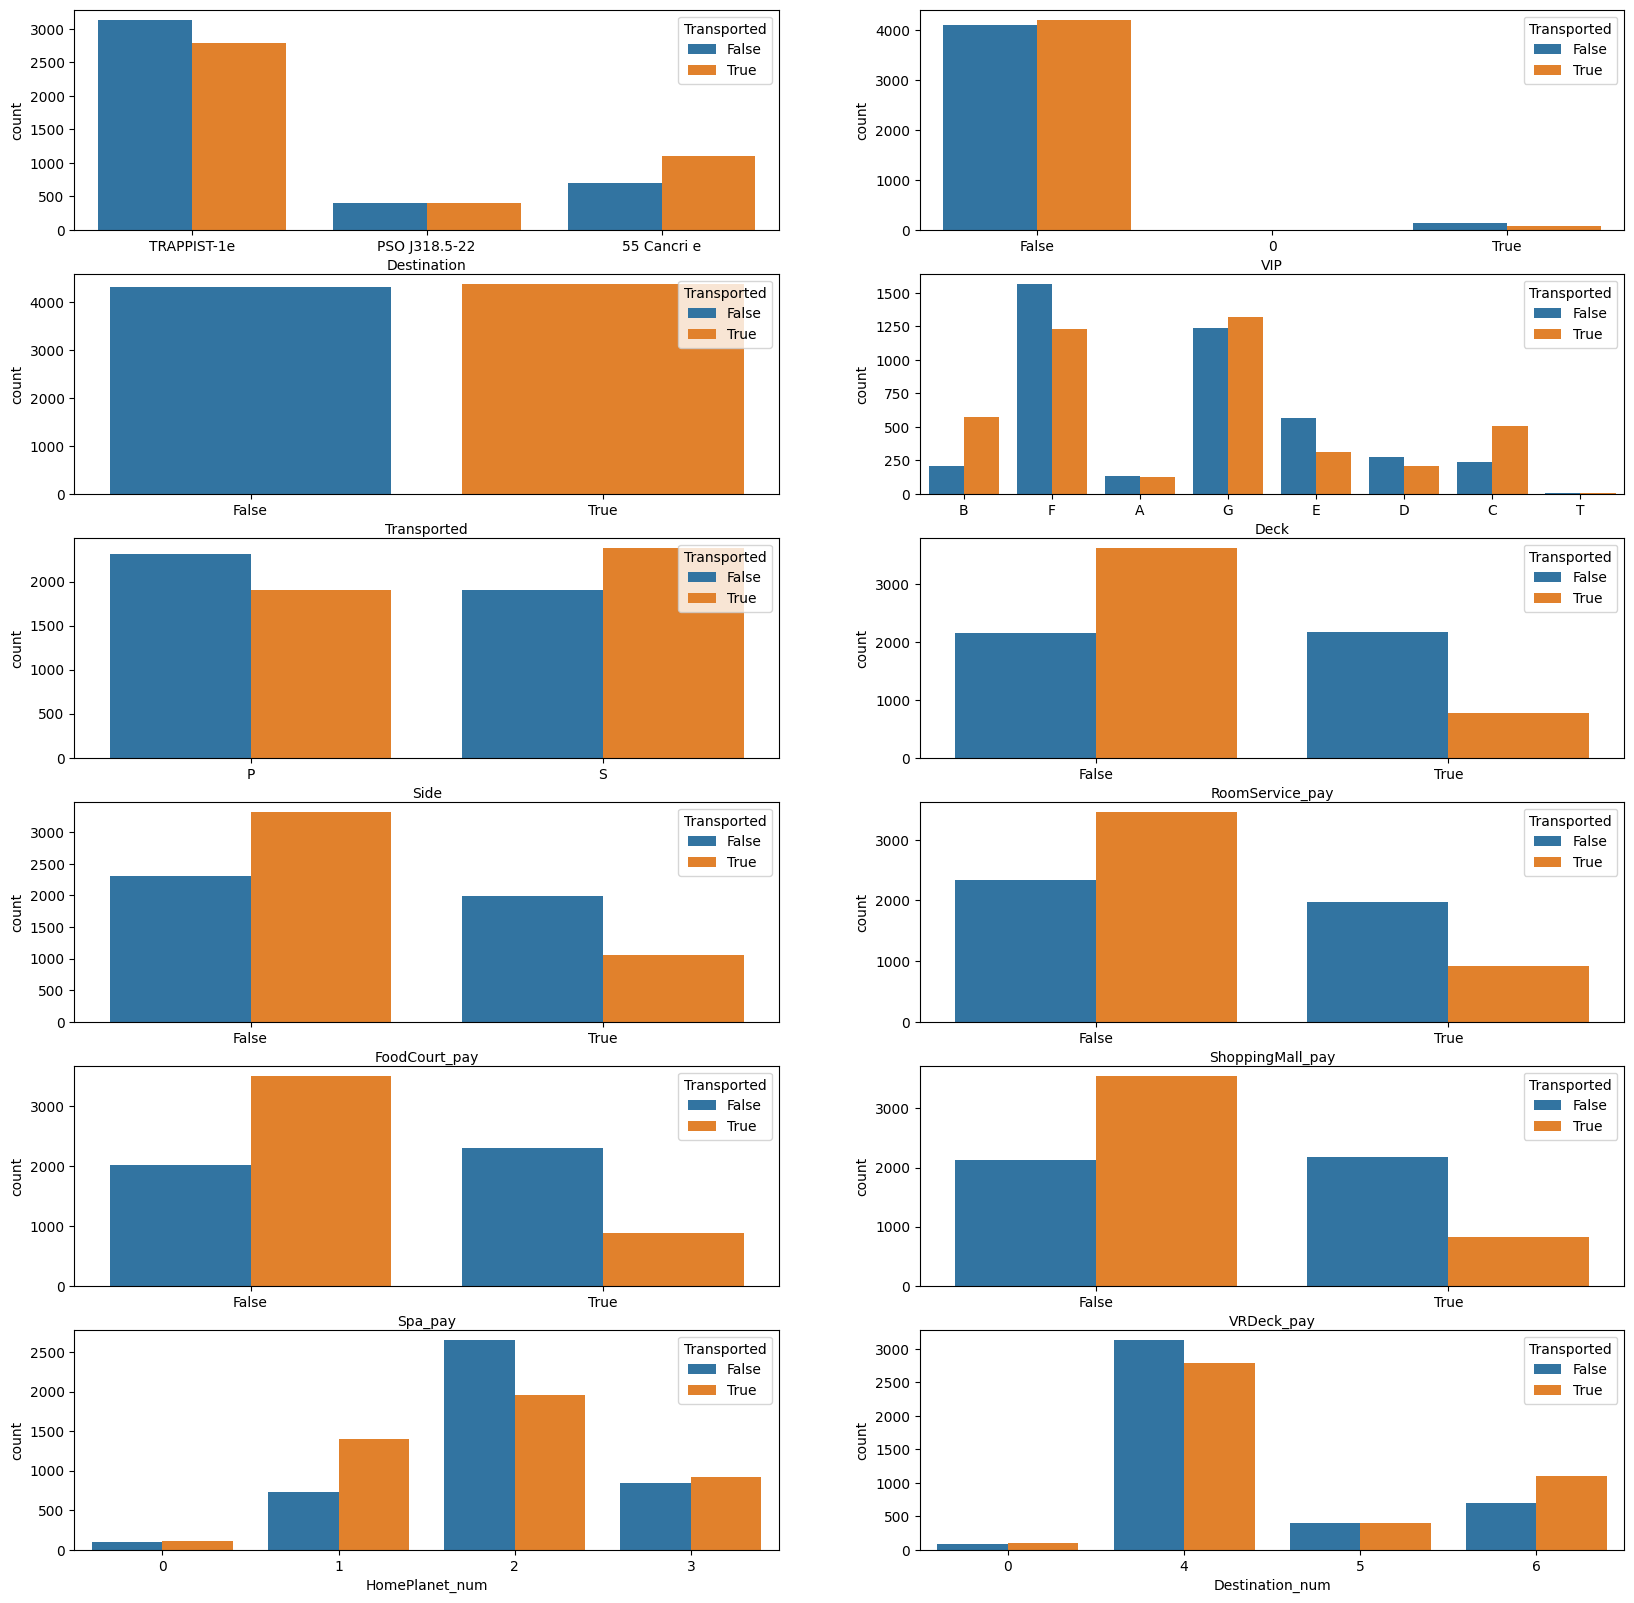

In [1121]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(20,20))
category_col_name = category_col.index.tolist()
category_col_name.remove("HomePlanet")
category_col_name.remove("CryoSleep")
for i in range(len(category_col_name)-1):
    row = i//2
    col = i % 2
    sns.countplot(data=train_df, x=category_col_name[i], ax=axes[row][col], hue="Transported")

### Outer

<Axes: xlabel='RoomService'>

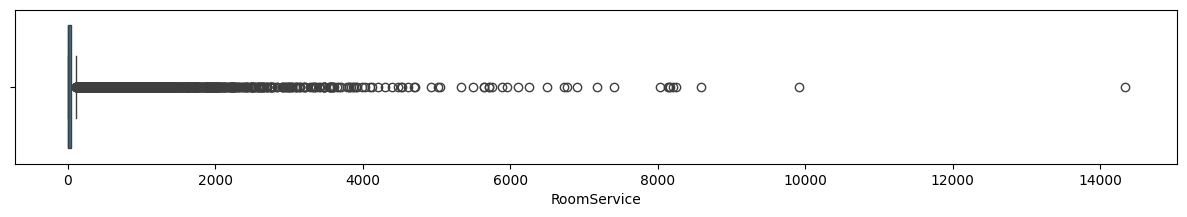

In [1144]:
plt.figure(figsize=(15,2))
sns.boxplot(x=train_df["RoomService"])

### OHE

In [1122]:
train_df = pd.get_dummies(train_df, columns=['Side'], dtype=int)

In [1123]:
train_df_num = train_df.select_dtypes(exclude='object')
cols = train_df_num.columns.tolist()
train_df['Transported'] = train_df['Transported'].astype(int)
train_df['VIP'] = train_df['VIP'].astype(int)
train_df_num

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,RoomService_pay,FoodCourt_pay,ShoppingMall_pay,Spa_pay,VRDeck_pay,HomePlanet_num,Destination_num,CryoSleep_num,Side_P,Side_S
0,39.0,0.0,0.0,0.0,0.0,0.0,False,1,False,False,False,False,False,1,4,0,1,0
1,24.0,109.0,9.0,25.0,549.0,44.0,True,2,True,True,True,True,True,2,4,0,0,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False,3,True,True,False,True,True,1,4,0,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False,3,False,True,True,True,True,1,4,0,0,1
4,16.0,303.0,70.0,151.0,565.0,2.0,True,4,True,True,True,True,True,2,4,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,41.0,0.0,6819.0,0.0,1643.0,74.0,False,9276,False,True,False,True,True,1,6,0,1,0
8689,18.0,0.0,0.0,0.0,0.0,0.0,False,9278,False,False,False,False,False,2,5,1,0,1
8690,26.0,0.0,0.0,1872.0,1.0,0.0,True,9279,False,False,True,True,False,2,4,0,0,1
8691,32.0,0.0,1049.0,0.0,353.0,3235.0,False,9280,False,True,False,True,True,1,6,0,0,1


In [1124]:
df_matrix = train_df[train_df_num.columns].iloc[:,:]
df_matrix["Transported"]=train_df["Transported"].astype(int)
df_matrix.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,RoomService_pay,FoodCourt_pay,ShoppingMall_pay,Spa_pay,VRDeck_pay,HomePlanet_num,Destination_num,CryoSleep_num,Side_P,Side_S
0,39.0,0.0,0.0,0.0,0.0,0.0,0,1,False,False,False,False,False,1,4,0,1,0
1,24.0,109.0,9.0,25.0,549.0,44.0,1,2,True,True,True,True,True,2,4,0,0,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,0,3,True,True,False,True,True,1,4,0,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,0,3,False,True,True,True,True,1,4,0,0,1
4,16.0,303.0,70.0,151.0,565.0,2.0,1,4,True,True,True,True,True,2,4,0,0,1


In [1125]:
df_corr = df_matrix.corr()

<Axes: >

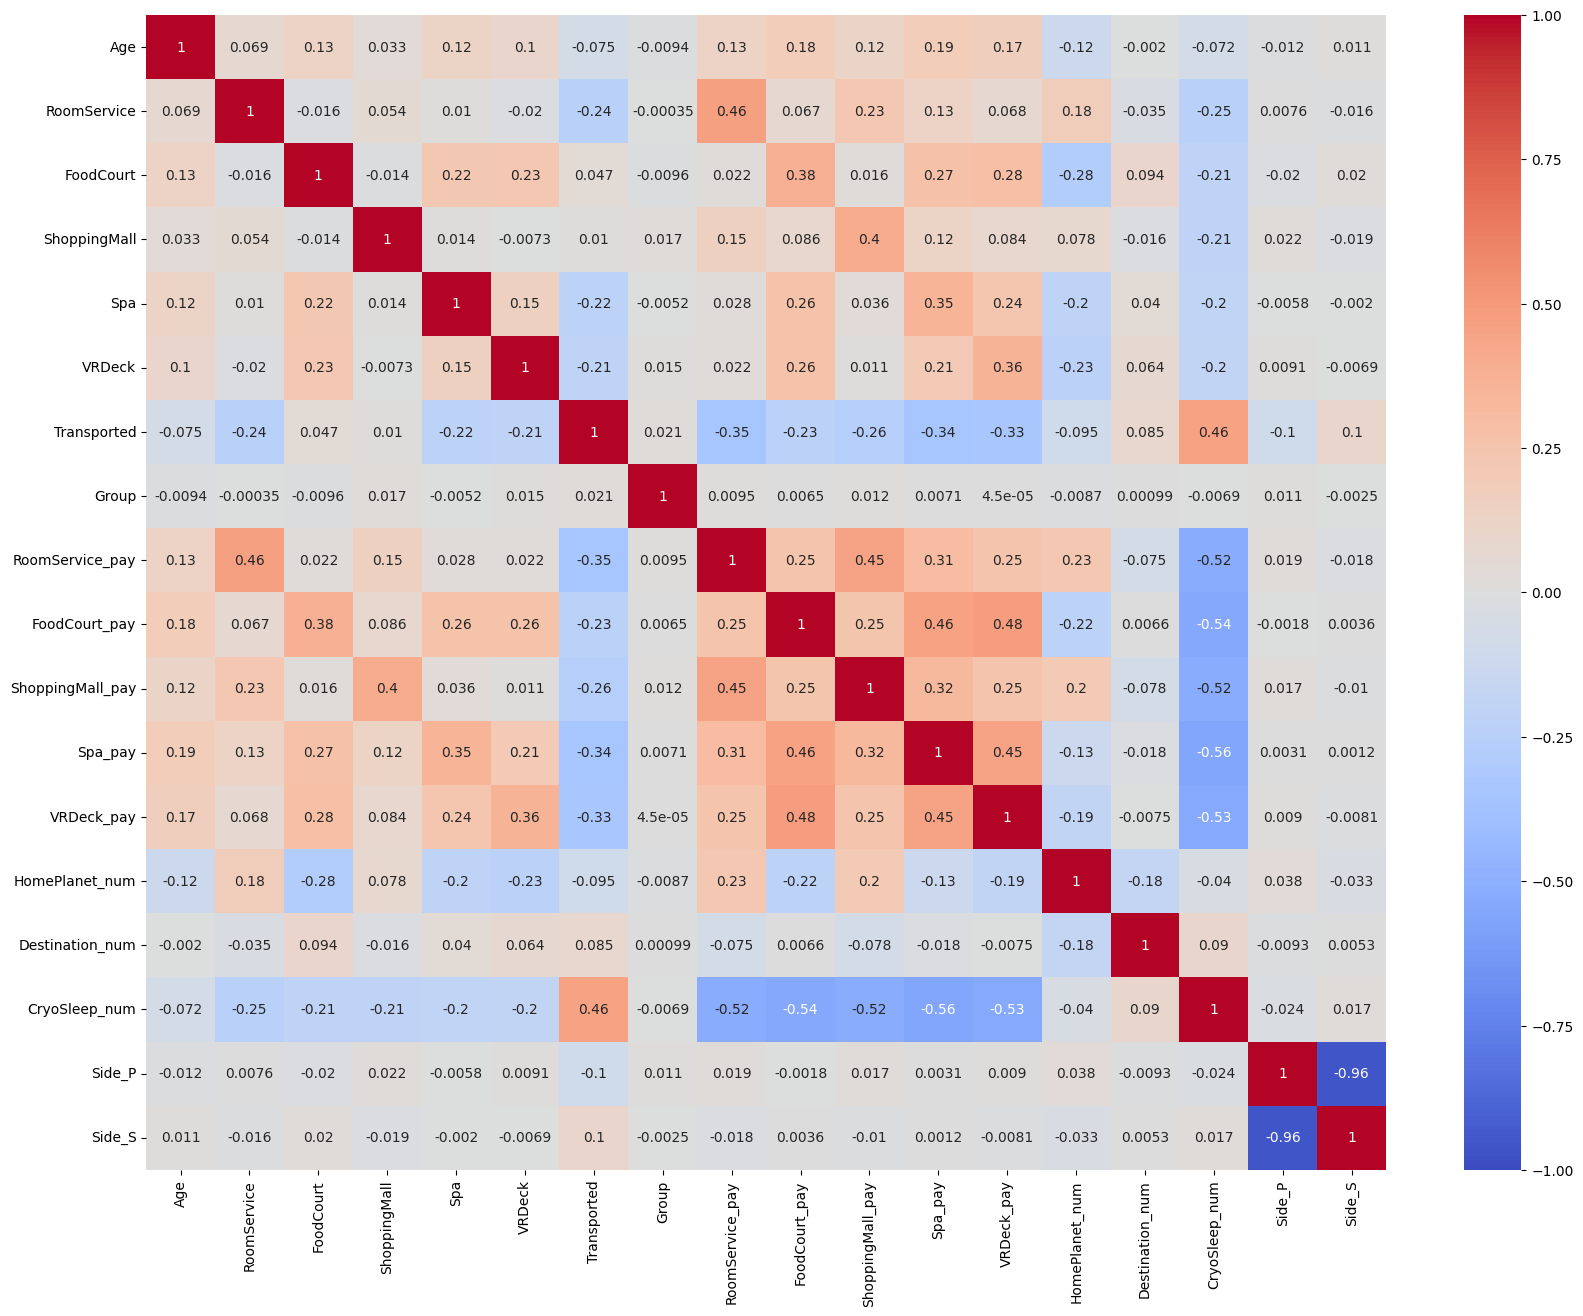

In [1126]:
plt.figure(figsize=(20,15))
sns.heatmap(df_corr, annot=True, vmax=1, vmin=-1, cmap="coolwarm", square=False)

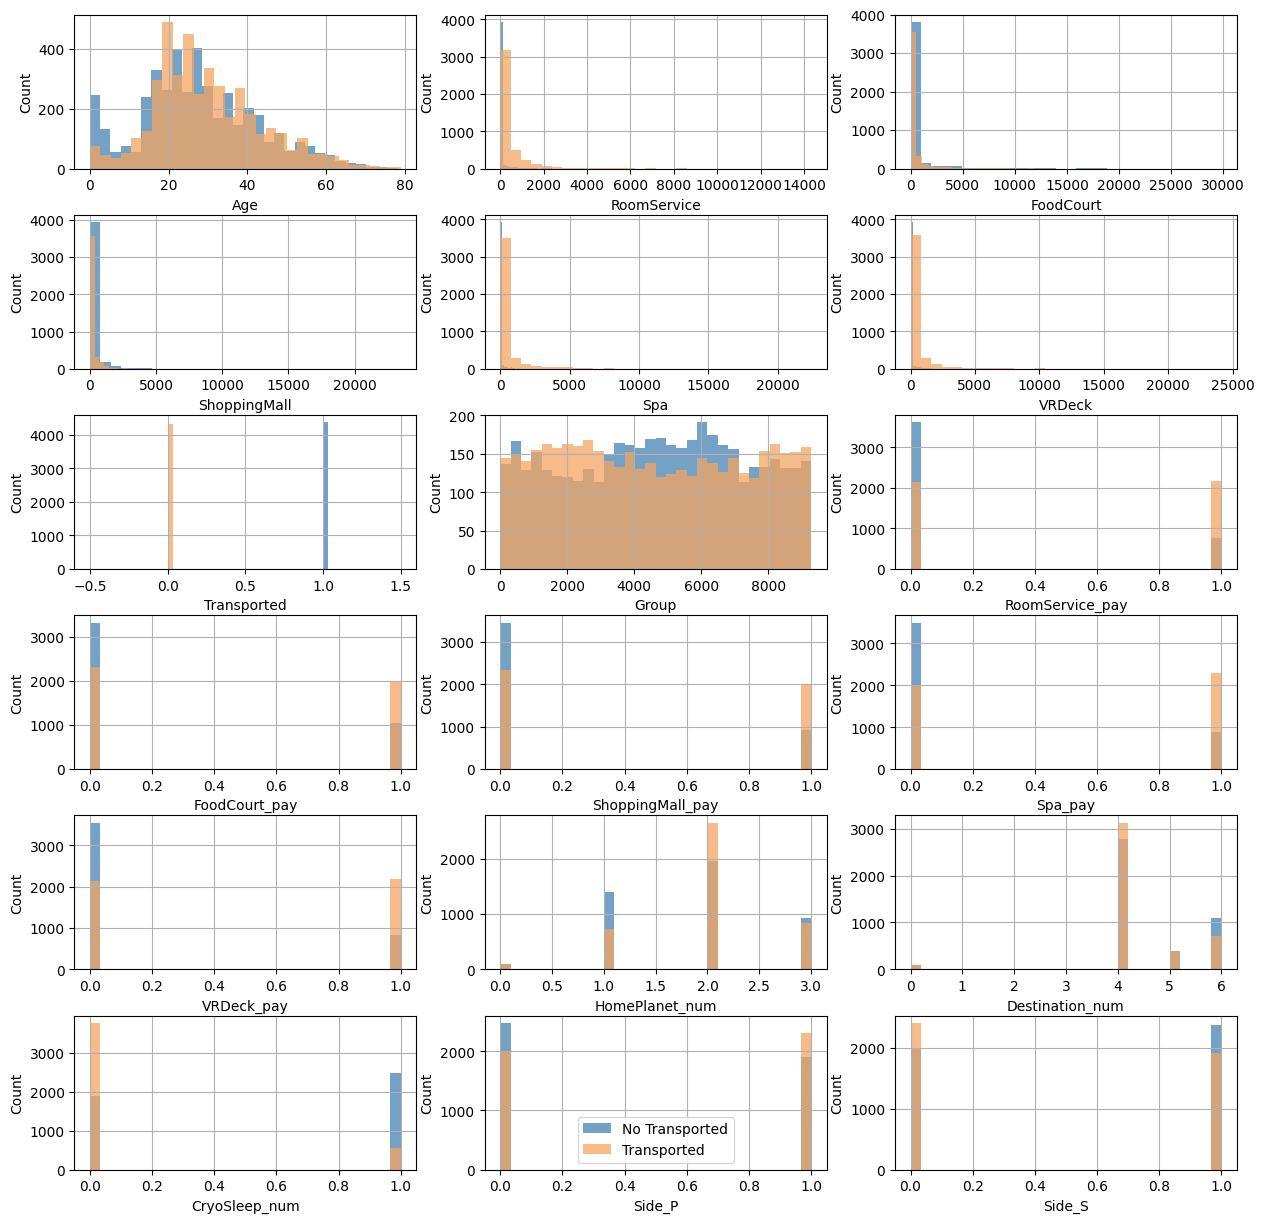

In [1127]:
train_df_0 = train_df[train_df["Transported"]==1]
train_df_1 = train_df[train_df["Transported"]==0]

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 15))
fig.subplots_adjust(hspace=0.3)  # Adjust vertical space between subplots

for i, col_name in enumerate(cols):
    row, col = divmod(i, 3)
    sns.histplot(train_df_0[col_name], label="No Transported", color="steelblue", linewidth=0, ax=axes[row, col], bins=30)
    sns.histplot(train_df_1[col_name], label="Transported", color="sandybrown", linewidth=0, ax=axes[row, col], bins=30)
    axes[row, col].grid(True)  # Display grid
    #axes[row, col].set_title(col_name, pad=10, loc='center', size=17)  # Centered title

# Adjust layout for legend
axes.flatten()[-2].legend(labels=["No Transported", "Transported"])

plt.show()


In [1128]:
feature_names = train_df.columns.tolist()
feature_names

['PassengerId',
 'HomePlanet',
 'CryoSleep',
 'Cabin',
 'Destination',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Name',
 'Transported',
 'Group',
 'Deck',
 'Num',
 'RoomService_pay',
 'FoodCourt_pay',
 'ShoppingMall_pay',
 'Spa_pay',
 'VRDeck_pay',
 'HomePlanet_num',
 'Destination_num',
 'CryoSleep_num',
 'Side_P',
 'Side_S']

### test 데이터도 똑같이 데이터 전처리 해주기

In [1129]:
# Name의 Null 값 Unknown으로 대체
test_df["Name"] = test_df["Name"].fillna("Unknown")
# VIP의 Null 값 0으로 대체
test_df["VIP"] = test_df["VIP"].fillna(0)

test_df["VIP"].astype(int)
# PaasengerId에서 _ 앞부분은 그룹을 의미 (가족일 수도 있고 아닐 수도)
test_df["Group"] = test_df["PassengerId"].apply(lambda x: x.split("_")[0]).astype(int)

test_df[["Deck", "Num", "Side"]] = test_df["Cabin"].str.split("/", expand=True)

# 분류하기 쉽도록 이름 대신 num 부여
test_df["HomePlanet_num"] = test_df["HomePlanet"].replace({"Europa":1, "Earth":2,"Mars":3})

# null 값은 0으로 채움
missing_or_infinite = test_df["HomePlanet_num"].isnull() | ~np.isfinite(test_df["HomePlanet_num"])
test_df["HomePlanet_num"].fillna(value=0, inplace=True)
test_df["HomePlanet_num"] = test_df["HomePlanet_num"].astype(int)

# 분류하기 쉽도록 이름 대신 num 부여
test_df["Destination_num"] = test_df["Destination"].replace({"TRAPPIST-1e":4, "PSO J318.5-22":5,"55 Cancri e":6})

# null 값은 0으로 채움
missing_or_infinite = test_df["Destination_num"].isnull() | ~np.isfinite(train_df["Destination_num"])
test_df["Destination_num"].fillna(value=0, inplace=True)
test_df["Destination_num"] = test_df["Destination_num"].astype(int)


# 분류하기 쉽도록 이름 대신 num 부여
test_df["CryoSleep_num"] = test_df["CryoSleep"].replace({"True":1, "False":0})

# null 값은 0으로 채움
missing_or_infinite = test_df["CryoSleep_num"].isnull() | ~np.isfinite(train_df["CryoSleep_num"])
test_df["CryoSleep_num"].fillna(value=0, inplace=True)
test_df["CryoSleep_num"] = test_df["CryoSleep_num"].astype(int)


test_df["VIP"] = test_df["VIP"].astype(int)

test_df = pd.get_dummies(test_df, columns=['Side'], dtype=int)

test_df["RoomService_pay"] = test_df["RoomService"] > 0
test_df["FoodCourt_pay"] = test_df["FoodCourt"] > 0
test_df["ShoppingMall_pay"] = test_df["ShoppingMall"] > 0
test_df["Spa_pay"] = test_df["Spa"] > 0
test_df["VRDeck_pay"] = test_df["VRDeck"] > 0

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       4277 non-null   object 
 1   HomePlanet        4190 non-null   object 
 2   CryoSleep         4184 non-null   object 
 3   Cabin             4177 non-null   object 
 4   Destination       4185 non-null   object 
 5   Age               4186 non-null   float64
 6   VIP               4277 non-null   int64  
 7   RoomService       4195 non-null   float64
 8   FoodCourt         4171 non-null   float64
 9   ShoppingMall      4179 non-null   float64
 10  Spa               4176 non-null   float64
 11  VRDeck            4197 non-null   float64
 12  Name              4277 non-null   object 
 13  Group             4277 non-null   int64  
 14  Deck              4177 non-null   object 
 15  Num               4177 non-null   object 
 16  HomePlanet_num    4277 non-null   int64  


### int나 float형이 아닌 것들이나 필요없는 feature 제거

In [1130]:
feature_names.remove("HomePlanet")
feature_names.remove("CryoSleep")
feature_names.remove("Cabin")
feature_names.remove("Name")
feature_names.remove("Destination")
feature_names.remove("Deck")
feature_names.remove("Transported")
feature_names.remove("PassengerId")
feature_names.remove("RoomService_pay")
feature_names.remove("FoodCourt_pay")
feature_names.remove("ShoppingMall_pay")
feature_names.remove("Spa_pay")
feature_names.remove("VRDeck_pay")
feature_names.remove("VIP")
feature_names.remove("Num")



feature_names

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Group',
 'HomePlanet_num',
 'Destination_num',
 'CryoSleep_num',
 'Side_P',
 'Side_S']

In [1131]:
X_train = train_df[feature_names]
y_train = train_df["Transported"]
X_train.head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,HomePlanet_num,Destination_num,CryoSleep_num,Side_P,Side_S
0,39.0,0.0,0.0,0.0,0.0,0.0,1,1,4,0,1,0
1,24.0,109.0,9.0,25.0,549.0,44.0,2,2,4,0,0,1
2,58.0,43.0,3576.0,0.0,6715.0,49.0,3,1,4,0,0,1
3,33.0,0.0,1283.0,371.0,3329.0,193.0,3,1,4,0,0,1
4,16.0,303.0,70.0,151.0,565.0,2.0,4,2,4,0,0,1


## 모델 학습 및 예측

### DecisionTree

In [1132]:
# from sklearn.tree import DecisionTreeClassifier
# dTreeModel = DecisionTreeClassifier(random_state=42, max_depth=5)
# dTreeModel.fit(X_train, y_train)

In [1133]:
# X_test = test_df[feature_names]
# y_pred = dTreeModel.predict(X_test)

In [1134]:
# dTreeModel.feature_importances_
# h = sns.barplot(x=dTreeModel.feature_importances_, y=feature_names)

### XGB

In [1135]:
from xgboost import XGBClassifier

xgbModel = XGBClassifier()
xgbModel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [1136]:
X_test = test_df[feature_names]
y_pred = xgbModel.predict(X_test)

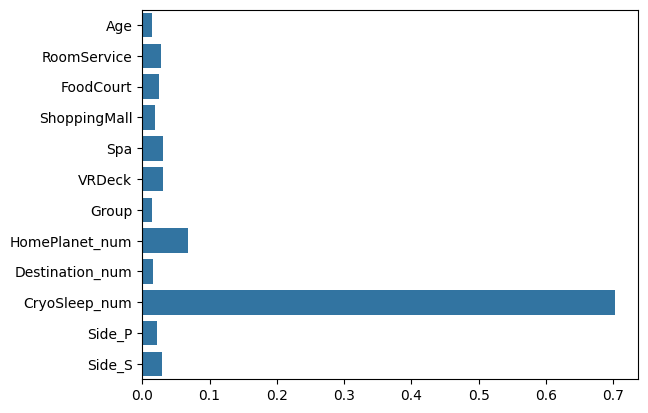

In [1137]:
xgbModel.feature_importances_
h = sns.barplot(x=xgbModel.feature_importances_, y=feature_names)

### LogisticRegression

In [1138]:
# train_df["Age"] = train_df["Age"].replace(np.nan, 27)
# test_df["Age"] = test_df["Age"].replace(np.nan, 27)

# feature_names.remove('RoomService')
# feature_names.remove('FoodCourt')
# feature_names.remove('ShoppingMall')
# feature_names.remove('Spa')
# feature_names.remove('VRDeck')

# X_train = train_df[feature_names]
# y_train = train_df["Transported"]

In [1139]:
# from sklearn.linear_model import LogisticRegression
# regressionModel = LogisticRegression(max_iter=10000)  
# regressionModel.fit(X_train,y_train)

In [1140]:
# X_test = test_df[feature_names]
# y_pred = regressionModel.predict(X_test)

## 결과

In [1141]:
results = [bool(value) for value in y_pred]

submission = pd.DataFrame(
    {"PassengerId": test_df["PassengerId"], "Transported": results}
)

submission.to_csv("submission.csv", index=False)

# 사이트 업로드 결과 정확도: 
# dTreeModel: 0.77544
# xgbModel: 0.79331
# LogisticRegression: 0.75169